<a href="https://colab.research.google.com/github/Jieuny1208/mypage/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install modules

In [ ]:
!pip install timm
!pip install anomalib
!pip install lightning
!pip install kornia

# BTAD Lab

In [ ]:
from pathlib import Path
import numpy as np
from PIL import Image
from torchvision.transforms.v2 import Resize
from torchvision.transforms.v2.functional import to_pil_image
from lightning.pytorch import LightningDataModule

from anomalib.data.image.btech import BTech, BTechDataset
from anomalib import TaskType

dataset_root = Path.cwd().parent / "datasets" / "BTech"

In [ ]:
btech_datamodule = BTech(
    root=dataset_root,
    category="01",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,
)

In [ ]:
btech_datamodule.prepare_data()
btech_datamodule.setup()

In [ ]:
# Train images
i, data = next(enumerate(btech_datamodule.train_dataloader()))
print(data.keys(), data["image"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 256, 256])


In [ ]:
# Test images
i, data = next(enumerate(btech_datamodule.test_dataloader()))
print(data.keys(), data["image"].shape, data["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])


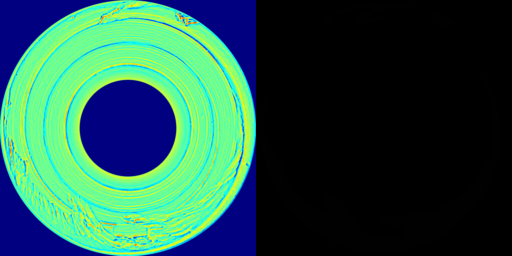

In [ ]:
img = to_pil_image(data["image"][0].clone())
msk = to_pil_image(data["mask"][0]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

In [ ]:
image_size = (256, 256)
transform = Resize(image_size, antialias=True)

In [ ]:
btech_dataset_classification_train = BTechDataset(
    root=dataset_root,
    category="01",
    transform=transform,
    split="train",
    task=TaskType.CLASSIFICATION,
)
btech_dataset_classification_train.samples.head()

,path,split,label,image_path,mask_path,label_index
0,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0000.png,/datasets/BTech/01/ground_truth/ok/0000.png,0
1,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0001.png,/datasets/BTech/01/ground_truth/ok/0001.png,0
2,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0002.png,/datasets/BTech/01/ground_truth/ok/0002.png,0
3,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0003.png,/datasets/BTech/01/ground_truth/ok/0003.png,0
4,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0004.png,/datasets/BTech/01/ground_truth/ok/0004.png,0


In [ ]:
sample = btech_dataset_classification_train[0]
print(sample.keys(), sample["image"].shape)

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256])


In [ ]:
# BTech Classification Test Set
btech_dataset_classification_test = BTechDataset(
    root=dataset_root,
    category="01",
    transform=transform,
    split="test",
    task=TaskType.CLASSIFICATION,
)
sample = btech_dataset_classification_test[0]
print(sample.keys(), sample["image"].shape, sample["image_path"], sample["label"])

dict_keys(['image_path', 'label', 'image']) torch.Size([3, 256, 256]) /datasets/BTech/01/test/ko/0000.png 1


In [ ]:
# BTech Segmentation Train Set
btech_dataset_segmentation_train = BTechDataset(
    root=dataset_root,
    category="01",
    transform=transform,
    split="train",
    task=TaskType.SEGMENTATION,
)
btech_dataset_segmentation_train.samples.head()

,path,split,label,image_path,mask_path,label_index
0,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0000.png,/datasets/BTech/01/ground_truth/ok/0000.png,0
1,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0001.png,/datasets/BTech/01/ground_truth/ok/0001.png,0
2,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0002.png,/datasets/BTech/01/ground_truth/ok/0002.png,0
3,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0003.png,/datasets/BTech/01/ground_truth/ok/0003.png,0
4,/datasets/BTech/01,train,ok,/datasets/BTech/01/train/ok/0004.png,/datasets/BTech/01/ground_truth/ok/0004.png,0


In [ ]:
# BTech Segmentation Test Set
btech_dataset_segmentation_test = BTechDataset(
    root=dataset_root,
    category="01",
    transform=transform,
    split="test",
    task=TaskType.SEGMENTATION,
)
sample = btech_dataset_segmentation_test[20]
print(sample.keys(), sample["image"].shape, sample["mask"].shape)

dict_keys(['image_path', 'label', 'image', 'mask']) torch.Size([3, 256, 256]) torch.Size([256, 256])


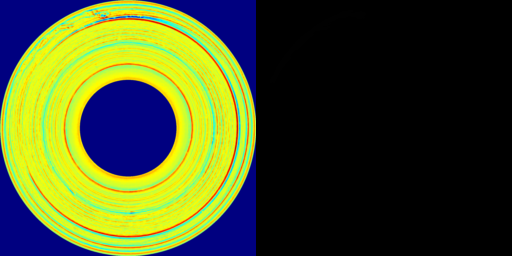

In [ ]:
# img = Image.open(sample["image_path"]).resize(image_size)
img = to_pil_image(sample["image"].clone())
msk = to_pil_image(sample["mask"]).convert("RGB")

Image.fromarray(np.hstack((np.array(img), np.array(msk))))

# Generator Architecture

## MAE Original

In [ ]:
from functools import partial

import torch
import torch.nn as nn

import numpy as np

from timm.models.vision_transformer import PatchEmbed, Block

In [ ]:
# Calculate position embedding
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width

    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [ ]:
class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics

        # patch -> embedding
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches # number of patches

        # cls token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        # position embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        # encoder input(embedding) -> encoder output(embedding)
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(depth)])
        # Normalization
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True) # output embedding

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim)) # Info about masking

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        # Decoder Input (Embedding) -> Decoder Output (Embedding)
        self.decoder_blocks = nn.ModuleList([ ## Decoder Module -> Transformer
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        ## Denormalization
        self.decoder_norm = norm_layer(decoder_embed_dim)
        # Output (flattened patch )
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True)
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights() # Initialized weights


    # Initialize learnable parameters
    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)


    # initialize weight for each "linear layer"
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    # image -> patch
    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x


    # patch -> image
    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs


    # image -> masked image
    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))

        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]

        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):

        # patch -> embedding
        x = self.patch_embed(x)
        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # imput -> masked input
        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        # patch -> encoder output
        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask

## GANomaly Encoder

In [ ]:
###
class GANEncoder(nn.Module):
    """
    DCGAN ENCODER NETWORK
    """
    def __init__(self, isize, nz, nc, ndf, ngpu, n_extra_layers=0, add_final_conv=True):
        super(GANEncoder, self).__init__()
        self.ngpu = ngpu
        assert isize % 16 == 0, "isize has to be a multiple of 16"

        main = nn.Sequential()
        # input is nc x isize x isize
        main.add_module('initial-conv-{0}-{1}'.format(nc, ndf),
                        nn.Conv2d(nc, ndf, 4, 2, 1, bias=False))
        main.add_module('initial-relu-{0}'.format(ndf),
                        nn.LeakyReLU(0.2, inplace=True))
        csize, cndf = isize / 2, ndf

        # Extra layers
        for t in range(n_extra_layers):
            main.add_module('extra-layers-{0}-{1}-conv'.format(t, cndf),
                            nn.Conv2d(cndf, cndf, 3, 1, 1, bias=False))
            main.add_module('extra-layers-{0}-{1}-batchnorm'.format(t, cndf),
                            nn.BatchNorm2d(cndf))
            main.add_module('extra-layers-{0}-{1}-relu'.format(t, cndf),
                            nn.LeakyReLU(0.2, inplace=True))

        while csize > 4:
            in_feat = cndf
            out_feat = cndf * 2
            main.add_module('pyramid-{0}-{1}-conv'.format(in_feat, out_feat),
                            nn.Conv2d(in_feat, out_feat, 4, 2, 1, bias=False))
            main.add_module('pyramid-{0}-batchnorm'.format(out_feat),
                            nn.BatchNorm2d(out_feat))
            main.add_module('pyramid-{0}-relu'.format(out_feat),
                            nn.LeakyReLU(0.2, inplace=True))
            cndf = cndf * 2
            csize = csize / 2

        # state size. K x 4 x 4
        if add_final_conv:
            main.add_module('final-{0}-{1}-conv'.format(cndf, 1),
                            nn.Conv2d(cndf, nz, 4, 1, 0, bias=False))

        self.main = main

    def forward(self, input):
        if self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output

## MAE Encoder/Decoder



In [ ]:
import torch
import torch.nn as nn
import torch.nn.parallel

from timm.models.vision_transformer import PatchEmbed, Block

In [ ]:
# mae encoder -> decoder의 출력값을 여기에 넣어서 다시 이미지 한장으로 만들 때 사용
def image_to_patches(images, patch_size):
    """
    이미지를 패치로 분할하는 함수

    Parameters:
    images (Tensor): 입력 이미지 텐서, 크기는 (batch_size, 3, height, width)
    patch_size (int): 한 패치의 크기 (가정: 정사각형 패치)

    Returns:
    Tensor: 패치 텐서, 크기는 (batch_size, num_patches, channels * patch_size * patch_size)
    """
    batch_size, channels, height, width = images.shape
    patches = images.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    patches = patches.contiguous().view(batch_size, channels, -1, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4).contiguous()
    patches = patches.view(batch_size, -1, channels * patch_size * patch_size)  # (batch_size, num_patches, patch_vector)
    return patches

def patches_to_embedding(patches, embed_dim):
    """
    패치를 임베딩으로 변환하는 함수

    Parameters:
    patches (Tensor): 패치 텐서, 크기는 (batch_size, num_patches, patch_vector_size)
    embed_dim (int): 임베딩 차원

    Returns:
    Tensor: 임베딩된 패치 텐서, 크기는 (batch_size, num_patches, embed_dim)
    """
    proj = torch.nn.Linear(patches.size(-1), embed_dim)  # patches.size(-1)는 patch_vector_size를 의미합니다.
    embeddings = proj(patches)
    return embeddings


# mae encoder -> decoder의 출력값을 여기에 넣어서 다시 이미지 한장으로 만들 때 사용
def patches_to_image(patches, image_size, patch_size, channels):
    """
    재조합 함수: 패치들을 원본 이미지로 재조합
    """
    batch_size, num_patches, _ = patches.shape
    # 패치를 원본 이미지 차원으로 reshape
    patches = patches.view(batch_size, num_patches, channels, patch_size, patch_size)
    # (batch_size, num_patches, channels, patch_size, patch_size)
    patches = patches.permute(0, 2, 1, 3, 4).contiguous()
    # (batch_size, channels, num_patches, patch_size, patch_size)
    grid_size = int(image_size / patch_size)
    images = patches.view(batch_size, channels, grid_size, grid_size, patch_size, patch_size)
    images = images.permute(0, 1, 2, 4, 3, 5).contiguous()
    images = images.view(batch_size, channels, image_size, image_size)
    return images

In [ ]:
# 입력 shape: (batch_size, num_patches, embed_dim)
class MAEEncoder(nn.Module):
    """Encoder for extracting latent vectors from masked images."""
    def __init__(self, embed_dim=1024, depth=24, num_heads=16, mlp_ratio=4., norm_layer=nn.LayerNorm):
        super(MAEEncoder, self).__init__()

        # Transformer blocks
        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)
        ])

        # Final normalization layer
        self.norm = norm_layer(embed_dim)

    def forward(self, x):
        # Process each transformer block
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        return x

In [ ]:
# patch 한개의 임베딩을 받아서 patch 한장 나옴
class MAEDecoder(nn.Module):
    def __init__(self, embed_dim=1024, decoder_embed_dim=512, decoder_depth=8,
                 decoder_num_heads=16, patch_size=16, in_chans=3,
                 mlp_ratio=4., norm_layer=nn.LayerNorm):
        super(MAEDecoder, self).__init__()

        # Project latent vectors to the decoder's dimension
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        # Transformer blocks for the decoder
        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)
        ])

        # Normalization layer at the end of the decoder
        self.decoder_norm = norm_layer(decoder_embed_dim)

        # Prediction layer to project the decoder outputs to the original patch dimensions
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True)

    def forward(self, x):
        # Embed latent vectors into the decoder dimension
        x = self.decoder_embed(x)

        # Process through each decoder block
        for block in self.decoder_blocks:
            x = block(x)
        x = self.decoder_norm(x)

        # Final layer to project back to the input size
        x = self.decoder_pred(x)
        return x


In [ ]:
##
class NetG(nn.Module):
    """
    GENERATOR NETWORK
    근데 이러면 MAEEncoder의 출력이랑 GANEncoder의 출력이랑 다른데 어떻게비교하지 Lenc
    """

    def __init__(self):
        super(NetG, self).__init__()
        self.encoder1 = MAEEncoder() # 출력 shape : (batch_size, num_patches, embed_dim)
        self.decoder = MAEDecoder() # 여기서 나온걸 data_utils로 이미지로 다시 만들고 원래 input이랑 비교하면 될듯?
        # self.encoder2 = GANEncoder(
        #     isize=64,             # 이미지의 한 변의 크기 (64x64)
        #     nz=100,               # 라텐트 벡터의 차원
        #     nc=3,                 # 입력 이미지의 채널 수 (RGB 이미지)
        #     ndf=64,               # 첫 번째 컨볼루션 레이어의 필터 수
        #     n_extra_layers=1,     # 추가 레이어의 수
        #     add_final_conv=True   # 마지막에 컨볼루션 레이어를 추가할지 여부
        # )

    def forward(self, x):
        latent_i = self.encoder1(x)
        gen_img = self.decoder(latent_i)
        gen_img = patches_to_image(gen_img, 64, 16, 3)  # 64는 최종 이미지 크기, 16은 패치 크기, 3은 채널 수

        # latent_o = self.encoder2(gen_img)
        return latent_i, gen_img #, latent_o

class ZeroGan(nn.Module):
    def __init__(self):
        super(ZeroGan,self).__init__()
        self.generator = NetG()
        # self.discriminator = NetD()

    def forward(self, x):
        # latent_i, gen_img, latent_o = self.generator(x)
        latent_i, gen_img = self.generator(x)
        print("latent_i.shape : " + str(latent_i.shape))
        print("gen_img.shape : " + str(gen_img.shape))
        # print("latent_o.shape : " + str(latent_o.shape))
        return latent_i, gen_img #, latent_o


In [ ]:
def load_data():
    """
    """

    btech_datamodule = BTech(
    root=dataset_root,
    # catogory
    category="01",
    image_size=256,
    train_batch_size=32,
    eval_batch_size=32,
    num_workers=0,
    task=TaskType.SEGMENTATION,
    )

    btech_datamodule.prepare_data()
    btech_datamodule.setup()

    dataloader = btech_datamodule.train_dataloader()
    return dataloader

In [ ]:
def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

In [ ]:
def train():

    model = ZeroGan()
    dataloader = load_data() # btad
    for i, batch in enumerate(dataloader):
        input= batch['image']
        labels = batch['label']
        print(input.shape)
        print(labels.shape)

        patched_imgs = image_to_patches(input , 64)
        embeddings = patches_to_embedding(patched_imgs, 1024)

        # latent_i, gen_img, latent_o = model(embeddings)
        latent_i, gen_img = model(embeddings)


In [ ]:
train()

torch.Size([32, 3, 256, 256])
torch.Size([32])


RuntimeError: shape '[32, 3, 16, 16, 16, 16]' is invalid for input of size 393216